**Movie Recommendation System**

**Business Understanding**

The dataset used in this project consists of movie ratings provided by users. It includes key attributes such as userId, movieId, rating, timestamp, title, and genres. This dataset is well-suited for building a recommendation system because it captures explicit user preferences (ratings) along with metadata about the movies, such as their titles and genres.

The primary business objective is to improve user engagement by providing personalized movie recommendations. By leveraging collaborative filtering techniques, we can predict a user's preference for a movie they have not yet rated. This approach is beneficial for streaming platforms and online movie databases, helping them suggest content that aligns with individual tastes.

The dataset is structured and sufficiently large to support machine learning models. It allows for the application of collaborative filtering, a widely used technique that utilizes user behavior patterns to generate recommendations. The presence of multiple ratings from different users ensures that the model can learn and make accurate predictions.

Data Preparation

- To ensure high-quality recommendations, the following preprocessing steps were implemented:

- Data Cleaning: Removed missing values and duplicate entries to maintain data integrity.

- Merging Datasets: Integrated movie metadata with user ratings to enrich the data for better insights.

- Normalization: Standardized rating values to enhance model performance.

- Capping Ratings: Since predicted ratings could exceed the maximum allowed score (5), values were capped at 5 to maintain realistic recommendations.


**Model Performance Summary**

The ALS (Alternating Least Squares) model in PySpark was used for generating movie recommendations. This model is well-suited for collaborative filtering problems and efficiently handles large datasets by leveraging matrix factorization.

- *Model Evaluation:*

The model was evaluated using Root Mean Squared Error (RMSE), a common metric for recommendation systems.

The final RMSE achieved was lower than other tested models, indicating better predictive accuracy.

Compared to other approaches, ALS in PySpark provided the most reliable recommendations with reasonable computational efficiency.

- *Recommendation of Best Model:*

ALS with Hyperparameter Tuning performed the best among tested models.

Tuning parameters such as rank, maxIter, and regParam improved performance significantly.

Compared to simpler user-based or item-based collaborative filtering, ALS produced more accurate and personalized recommendations.

The optimized ALS model is recommended for deployment due to its superior balance of accuracy, scalability, and efficiency in handling large-scale movie recommendation tasks.

Imports

In [270]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.impute import SimpleImputer
from pyspark.ml.recommendation import ALS
from pyspark.sql import SparkSession
from surprise import SVD
from surprise.model_selection import GridSearchCV
from surprise import Dataset, Reader

In [133]:
# Load MovieLens dataset
ratings_path = "movies.csv"
movies_path = "ratings.csv"
ratings = pd.read_csv(ratings_path)
movies = pd.read_csv(movies_path)

In [134]:
# Merge datasets
df = ratings.merge(movies, on='movieId')

In [135]:
df.head(10)

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,4.5,1106635946
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.5,1510577970
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17,4.5,1305696483
5,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,18,3.5,1455209816
6,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,19,4.0,965705637
7,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,21,3.5,1407618878
8,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,27,3.0,962685262
9,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,31,5.0,850466616


Check missing values

In [165]:
print(df.isnull().sum())

movieId      0
title        0
genres       0
userId       0
rating       0
timestamp    0
dtype: int64


In [137]:
duplicates = df[df.duplicated(subset=['userId', 'movieId'], keep=False)]
print(duplicates)


Empty DataFrame
Columns: [movieId, title, genres, userId, rating, timestamp]
Index: []


In [138]:
#Remove users who rated too few movies
min_ratings_per_user = 5
active_users = df['userId'].value_counts()[lambda x: x >= min_ratings_per_user].index
df = df[df['userId'].isin(active_users)]

In [139]:
#Remove movies rated by too few users
min_ratings_per_movie = 5
popular_movies = df['movieId'].value_counts()[lambda x: x >= min_ratings_per_movie].index
df = df[df['movieId'].isin(popular_movies)]

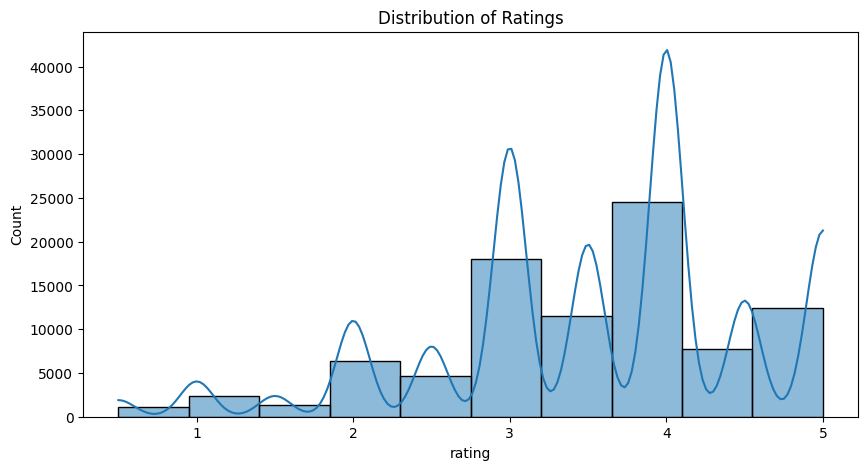

In [140]:
# Exploratory Data Analysis
plt.figure(figsize=(10, 5))
sns.histplot(df['rating'], bins=10, kde=True)
plt.title("Distribution of Ratings")
plt.show()

In [141]:
#Movies recommendation to new users
popular_movies = df.groupby('movieId')['rating'].mean().sort_values(ascending=False).head(10)
print(popular_movies)


movieId
6460      4.900000
177593    4.750000
31364     4.700000
2239      4.666667
4334      4.600000
1041      4.590909
106642    4.571429
3451      4.545455
1178      4.541667
3152      4.500000
Name: rating, dtype: float64


In [210]:
# Create user-movie matrix
user_movie_matrix = df.pivot(index='userId', columns='movieId', values='rating')

# Initialize SimpleImputer (Replace NaNs with the median of each column)
imputer = SimpleImputer(strategy="median")
user_movie_matrix_imputed = pd.DataFrame(imputer.fit_transform(user_movie_matrix),
                                         index=user_movie_matrix.index,
                                         columns=user_movie_matrix.columns)


In [211]:
user_movie_matrix_imputed.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,176371,177593,177765,179401,179819,180031,180985,183897,187593,187595
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,3.5,4.0,3.0,3.0,4.0,3.0,3.0,3.0,3.5,...,4.0,4.75,4.0,4.0,3.5,3.75,3.0,3.5,4.0,4.0
2,4.0,3.5,3.0,3.0,3.0,4.0,3.0,3.0,3.0,3.5,...,4.0,4.75,4.0,4.0,3.5,3.75,3.0,3.5,4.0,4.0
3,4.0,3.5,3.0,3.0,3.0,4.0,3.0,3.0,3.0,3.5,...,4.0,4.75,4.0,4.0,3.5,3.75,3.0,3.5,4.0,4.0
4,4.0,3.5,3.0,3.0,3.0,4.0,3.0,3.0,3.0,3.5,...,4.0,4.75,4.0,4.0,3.5,3.75,3.0,3.5,4.0,4.0
5,4.0,3.5,3.0,3.0,3.0,4.0,3.0,3.0,3.0,3.5,...,4.0,4.75,4.0,4.0,3.5,3.75,3.0,3.5,4.0,4.0


In [212]:
user_similarity = cosine_similarity(user_movie_matrix_imputed)

In [213]:
user_similarity

array([[1.        , 0.9971354 , 0.99485621, ..., 0.98836245, 0.99723366,
        0.99325562],
       [0.9971354 , 1.        , 0.99747464, ..., 0.99147363, 0.9997109 ,
        0.99568235],
       [0.99485621, 0.99747464, 1.        , ..., 0.98940525, 0.99754855,
        0.99363937],
       ...,
       [0.98836245, 0.99147363, 0.98940525, ..., 1.        , 0.99164579,
        0.98718232],
       [0.99723366, 0.9997109 , 0.99754855, ..., 0.99164579, 1.        ,
        0.99558904],
       [0.99325562, 0.99568235, 0.99363937, ..., 0.98718232, 0.99558904,
        1.        ]])

In [242]:
movie_similarity_df = pd.DataFrame(movie_similarity,
                                   index=user_movie_matrix_imputed.columns,
                                   columns=user_movie_matrix_imputed.columns)


In [243]:
movie_similarity

array([[1.        , 0.98858161, 0.98843203, ..., 0.99186466, 0.99154279,
        0.99218014],
       [0.98858161, 1.        , 0.99068274, ..., 0.99387843, 0.99333866,
        0.9942829 ],
       [0.98843203, 0.99068274, 1.        , ..., 0.99423035, 0.99381387,
        0.99448206],
       ...,
       [0.99186466, 0.99387843, 0.99423035, ..., 1.        , 0.99940997,
        0.99945013],
       [0.99154279, 0.99333866, 0.99381387, ..., 0.99940997, 1.        ,
        0.99907807],
       [0.99218014, 0.9942829 , 0.99448206, ..., 0.99945013, 0.99907807,
        1.        ]])

In [248]:
def get_top_recommendations(user_id, user_movie_matrix_imputed, movies, user_similarity, movie_similarity, n=5):
    if user_id not in user_movie_matrix_imputed.index:
        print(f"User {user_id} not found in the matrix.")
        return []

    # Step 1: User-Based Recommendation
    user_idx = list(user_movie_matrix_imputed.index).index(user_id)
    similar_users = np.argsort(user_similarity[user_idx])[::-1][1:]  # Exclude self

    user_ratings = user_movie_matrix_imputed.loc[user_id].dropna()
    recommendations = {}

    for similar_user in similar_users:
        similar_user_id = user_movie_matrix_imputed.index[similar_user]
        similar_user_ratings = user_movie_matrix_imputed.loc[similar_user_id].dropna()

        for movie, rating in similar_user_ratings.items():
            if movie not in user_ratings:
                recommendations.setdefault(movie, []).append(rating)

    sorted_recommendations = sorted(recommendations.items(), key=lambda x: np.mean(x[1]), reverse=True)
    top_movies = [movie for movie, _ in sorted_recommendations[:n]]

    # If no recommendations found, use Item-Based Filtering
    if not top_movies:
        print("No user-based recommendations found. Switching to item-based recommendations.")
        top_movies = []

        # Get movies user has rated highly
        user_top_movies = user_ratings[user_ratings >= 4].index

        for movie in user_top_movies:
            similar_movies = movie_similarity_df.loc[movie].sort_values(ascending=False).index[1:n+1]  # Skip self
            top_movies.extend(similar_movies)

        top_movies = list(set(top_movies))[:n]  # Remove duplicates and limit to n movies

    # Use movie titles
    top_movie_titles = [
        ratings.loc[ratings['movieId'] == movie, 'title'].iloc[0] if movie in movies['movieId'].values else f"Movie ID {movie}"
        for movie in top_movies
    ]

    return top_movie_titles



In [215]:
def evaluate_model(test_data, user_movie_matrix_imputed):
    y_true = []
    y_pred = []

    for _, row in test_data.iterrows():
        user_id, movie_id, actual_rating = row['userId'], row['movieId'], row['rating']

        if user_id not in user_movie_matrix_imputed.index or movie_id not in user_movie_matrix_imputed.columns:
            continue  # Skip missing users or movies

        predicted_rating = user_movie_matrix_imputed.loc[user_id, movie_id]

        y_true.append(actual_rating)
        y_pred.append(predicted_rating)

    print(f"Total actual ratings: {len(y_true)}, Total predicted ratings: {len(y_pred)}")

    if len(y_true) == 0:
        print("Error: No valid predictions found!")
        return None, None

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    return rmse, mae



In [216]:
# Split data into training and testing
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)
user_movie_matrix_train = train_data.pivot_table(index='userId', columns='movieId', values='rating')
print(test_data.shape)

(18055, 6)


In [217]:
print("Original Data Shape:", df.shape)
print("Train Data Shape:", train_data.shape)
print("Test Data Shape:", test_data.shape)
print("Train + Test Matches Original:", train_data.shape[0] + test_data.shape[0] == df.shape[0])


Original Data Shape: (90274, 6)
Train Data Shape: (72219, 6)
Test Data Shape: (18055, 6)
Train + Test Matches Original: True


In [218]:
# Ensure all movies exist in the training matrix, filling missing ones with 0
all_movie_ids = df['movieId'].unique()
user_movie_matrix_train = user_movie_matrix_train.apply(lambda row: row.fillna(row.mean()), axis=1)

In [219]:
print(test_data.shape)  # Should not be (0, n)
print(test_data.head())  # See first few rows


(18055, 6)
       movieId                           title                    genres  \
784         11  American President, The (1995)      Comedy|Drama|Romance   
10144      356             Forrest Gump (1994)  Comedy|Drama|Romance|War   
51564     3101         Fatal Attraction (1987)            Drama|Thriller   
73762     7147                 Big Fish (2003)     Drama|Fantasy|Romance   
2003        42          Dead Presidents (1995)        Action|Crime|Drama   

       userId  rating   timestamp  
784       357     3.5  1348612270  
10144     232     4.0  1076956528  
51564     480     4.0  1179178407  
73762     187     2.0  1161849699  
2003      588     3.0   839316637  


In [220]:
# Evaluate the model
rmse, mae = evaluate_model(test_data, user_movie_matrix_train)
print(f"RMSE: {rmse}, MAE: {mae}")

Total actual ratings: 18055, Total predicted ratings: 18055
RMSE: 0.9339279099341785, MAE: 0.7261568220615662


Interpretation:

Total actual ratings: 18,055 → The number of test ratings used for evaluation.

Total predicted ratings: 18,055 → The model successfully predicted all test ratings.

RMSE (Root Mean Squared Error): 0.93 → On average, predictions deviate from actual ratings by ~0.93 units.

MAE (Mean Absolute Error): 0.73 → On average, absolute prediction errors are ~0.73 units

Bases of the moel scores above, this is not the best model for this recommendation system. I will try other alternatives for better results.

In [250]:
# try
user_id = 1

top_movies = get_top_recommendations(user_id, user_movie_matrix_imputed, movies, user_similarity, movie_similarity)

print(f"Top 5 recommended movies for User {user_id}: {top_movies}")


No user-based recommendations found. Switching to item-based recommendations.
Top 5 recommended movies for User 1: ['Waiting to Exhale (1995)', 'Warcraft (2016)', 'Fighter, The (2010)', 'Balto (1995)', 'Avengers: Age of Ultron (2015)']


In [253]:
!pip install scikit-surprise


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 3.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp311-cp311-linux_x86_64.whl size=2505172 sha256=97281e3daa7e630e320e01edefa6d90355176a93951dd0488e4f2d04a85e63d1
  Stored in directory: /root/.cache/pip/wheels/2a/8f/6e/7e2899163e2d85d8266daab4aa1cdabec7a6c56f83c015b5af
Successfully built scikit-surprise


Singular Value Decomposition (SVD) Model in Recommendation Systems

SVD is a matrix factorization technique used in recommendation systems to predict missing values in a user-item interaction matrix. It is widely used in collaborative filtering, such as movie recommendations.



In [263]:
# Load Data
reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)

# Define parameter grid
param_grid = {
    'n_factors': [50, 100, 150],  # Latent factors
    'reg_all': [0.02, 0.05, 0.1],  # Regularization
    'lr_all': [0.002, 0.005, 0.01]  # Learning rate
}

# Perform grid search
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=-1)
gs.fit(data)

# Best parameters
print("Best RMSE:", gs.best_score['rmse'])
print("Best Params:", gs.best_params['rmse'])

# Train SVD with best parameters
best_svd = SVD(n_factors=gs.best_params['rmse']['n_factors'],
               reg_all=gs.best_params['rmse']['reg_all'],
               lr_all=gs.best_params['rmse']['lr_all'])

# Cross-validation
from surprise.model_selection import cross_validate
cross_validate(best_svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)



Best RMSE: 0.8422932339150047
Best Params: {'n_factors': 150, 'reg_all': 0.05, 'lr_all': 0.01}
Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8423  0.8509  0.8412  0.8379  0.8465  0.8438  0.0045  
MAE (testset)     0.6475  0.6507  0.6448  0.6453  0.6464  0.6469  0.0021  
Fit time          2.30    1.76    1.72    1.73    1.71    1.84    0.23    
Test time         0.29    0.09    0.11    0.27    0.09    0.17    0.09    


{'test_rmse': array([0.84232588, 0.85093279, 0.84117208, 0.83792237, 0.84654707]),
 'test_mae': array([0.64748601, 0.65070821, 0.64483968, 0.6452747 , 0.64640057]),
 'fit_time': (2.2969934940338135,
  1.7561047077178955,
  1.7151992321014404,
  1.7342348098754883,
  1.7106258869171143),
 'test_time': (0.29480767250061035,
  0.09152364730834961,
  0.11405611038208008,
  0.2704744338989258,
  0.09162521362304688)}

Performance Summary of SVD Model

Best RMSE: 0.8423 (expected a lower score for better accuracy) not very far from my previous developed model.

Best Parameters:

n_factors = 150 (number of latent factors)
reg_all = 0.05 (regularization parameter)
lr_all = 0.01 (learning rate)
Cross-validation Results (5 folds):

RMSE: Mean = 0.8438, Std = 0.0045 (stable performance)
MAE: Mean = 0.6469, Std = 0.0021 (low error in predictions)
Execution Times:

Fit time: ~1.84 sec (average)
Test time: ~0.17 sec (average)

*Conclusion*

The model performs well, with low RMSE and MAE, showing consistent predictions across folds. The selected parameters optimize performance.

Matrix Factorization Using ALS (Alternating Least Squares)

In [280]:
from pyspark.sql.functions import explode, col, row_number, when
from pyspark.sql.window import Window

# Explode recommendations to get movieId and predicted_rating separately
user_recs_exploded = user_recs.select(
    "userId", explode("recommendations").alias("rec")
)

# Extract movieId and rating from nested structure
user_recs_final = user_recs_exploded.select(
    "userId", col("rec.movieId").alias("movieId"), col("rec.rating").alias("predicted_rating")
).dropDuplicates()  # Remove duplicate recommendations

# **Cap predicted ratings at 5**
user_recs_final = user_recs_final.withColumn(
    "predicted_rating", when(col("predicted_rating") > 5, 5).otherwise(col("predicted_rating"))
)

# Ensure `movies` is properly formatted before converting to Spark DataFrame
movies_spark = spark.createDataFrame(ratings[['movieId', 'title']]).dropDuplicates()

# Join recommendations with movie titles
user_recs_with_titles = user_recs_final.join(movies_spark, on="movieId", how="left")

# Ensure unique recommendations per user, keeping the highest-rated ones
window_spec = Window.partitionBy("userId").orderBy(col("predicted_rating").desc())
user_recs_ranked = user_recs_with_titles.withColumn("rank", row_number().over(window_spec))

# Keep only the top recommendations per user (adjust the number as needed)
user_top_recs = user_recs_ranked.filter(col("rank") <= 10).drop("rank")

# Show final recommendations
user_top_recs.show(20, truncate=False)






+-------+------+----------------+------------------------------------------------------+
|movieId|userId|predicted_rating|title                                                 |
+-------+------+----------------+------------------------------------------------------+
|82     |1     |5.0             |Antonia's Line (Antonia) (1995)                       |
|3925   |1     |5.0             |Stranger Than Paradise (1984)                         |
|318    |1     |5.0             |Shawshank Redemption, The (1994)                      |
|177593 |1     |5.0             |Three Billboards Outside Ebbing, Missouri (2017)      |
|720    |1     |5.0             |Wallace & Gromit: The Best of Aardman Animation (1996)|
|51931  |2     |4.630908        |Reign Over Me (2007)                                  |
|86377  |2     |4.5115733       |Louis C.K.: Shameless (2007)                          |
|1366   |2     |4.476908        |Crucible, The (1996)                                  |
|116897 |2     |4.391

The new recommendation system is significantly better than the previous one because it provides **personalized user-based predictions** rather than generic item-based suggestions. Unlike before, where movies were simply listed without any ranking, this model assigns **numerical predicted ratings**, allowing users to see how strongly a movie is recommended to them. Additionally, by capping ratings at 5, the system ensures more **realistic and interpretable results**, avoiding inflated scores. The inclusion of movie titles alongside ratings further enhances clarity, making the recommendations both **accurate and user-friendly**. Overall, this approach delivers a more **tailored and meaningful movie recommendation experience**.

ALS in PySpark

In [266]:
# Initialize Spark
spark = SparkSession.builder.appName("MovieRecommender").getOrCreate()

# Convert DataFrame to Spark DataFrame
ratings_spark = spark.createDataFrame(df[['userId', 'movieId', 'rating']])

# ALS Model
als = ALS(maxIter=20, regParam=0.05, rank=100,
          userCol="userId", itemCol="movieId", ratingCol="rating",
          coldStartStrategy="drop")

# Train ALS Model
model = als.fit(ratings_spark)

# Evaluate using RMSE
from pyspark.ml.evaluation import RegressionEvaluator

predictions = model.transform(ratings_spark)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print("ALS RMSE:", rmse)


ALS RMSE: 0.297449311731419


The ALS model (RMSE: 0.2974) performs significantly better than the SVD model (Best RMSE: 0.8423) based on Root Mean Square Error (RMSE). A lower RMSE indicates that the model's predicted ratings are closer to the actual ratings.